In [2]:
import requests
from datetime import date, timedelta, datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from scipy.stats import pearsonr
import seaborn as sns

In [3]:
#connecting api
from api_key_coingecko import API_KEY


url = f"https://api.coingecko.com/api/v3/coins/bitcoin/market_chart" #api end point 

days_to_analyse = 2
currency = 'usd'

headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": API_KEY
}

params = {
    'vs_currency' : currency,
    'days' : str(days_to_analyse)
}

response = requests.get(url, params=params, headers=headers)
data = response.json()

In [4]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [5]:
#extract prices
def load_token_prices(days, currency = 'usd', token = None):
    
    url = f"https://api.coingecko.com/api/v3/coins/{token}/market_chart"
    
    params = {
        'vs_currency': currency,
        'days': days
    }
    response = requests.get(url, params=params, headers=headers)
    data = response.json()

    prices = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
    prices['timestamp'] = pd.to_datetime(prices['timestamp'], unit='ms')
    prices.set_index('timestamp', inplace=True)

    return prices
    

In [6]:
#extract volumes
def load_token_volumes(days, currency = 'usd', token = None):
    
    url = f"https://api.coingecko.com/api/v3/coins/{token}/market_chart" 
    
    params = {
        'vs_currency': currency,
        'days': days
    }
    response = requests.get(url, params=params, headers=headers)
    data = response.json()

    volumes = pd.DataFrame(data['total_volumes'], columns=['timestamp', 'total_volume'])
    volumes['timestamp'] = pd.to_datetime(volumes['timestamp'], unit='ms')
    volumes.set_index('timestamp', inplace=True)

    return volumes

In [7]:
def calculate_volatility(prices, days):
    results = []
    for i in range(1, days + 1):  # loop to analyse each day hourly from selected (today-n) days until today
        day = datetime.today() - timedelta(days=i) 
        next_day = day + timedelta(days=1)

        daily = prices[(prices.index >= day) & (prices.index < next_day)] #new list with prices by day
        daily= daily.copy()
        daily['return'] = daily['price'].pct_change() # calculating hourly returns for every day
        volatility = daily['return'].std() # calculating volatility for every day in week
        
        results.append({ # adding result to new the empty list
           'date': day.date(), 
         'weekday' : day.strftime('%A'),
         'volatility' : volatility
    })

    df = pd.DataFrame(results)
    df['weekday'] = pd.Categorical(df['weekday'], categories=weekday_order, ordered=True)

    return df

In [8]:
def calculate_volume(volumes, days):
    results = []
    for i in range(1,days + 1):
        day = datetime.today() - timedelta(days=i)
        next_day = day + timedelta(days=1)

        daily = volumes[(volumes.index >= day) & (volumes.index < next_day)] #new list with total_volumes by day
        daily= daily.copy()
        sum_volume = daily['total_volume'].sum() # sum hourly volumes
        results.append({ # adding result to new the empty list
         'date': day.date(),
         'weekday' : day.strftime('%A'),
         'volume' : sum_volume
    })

    df = pd.DataFrame(results) 
    df['weekday'] = pd.Categorical(df['weekday'],categories=weekday_order, ordered=True) #set right order of weekdays (default alphabetical order)

    return df


Volatility of Bitcoin for last 14 hours:0.0065


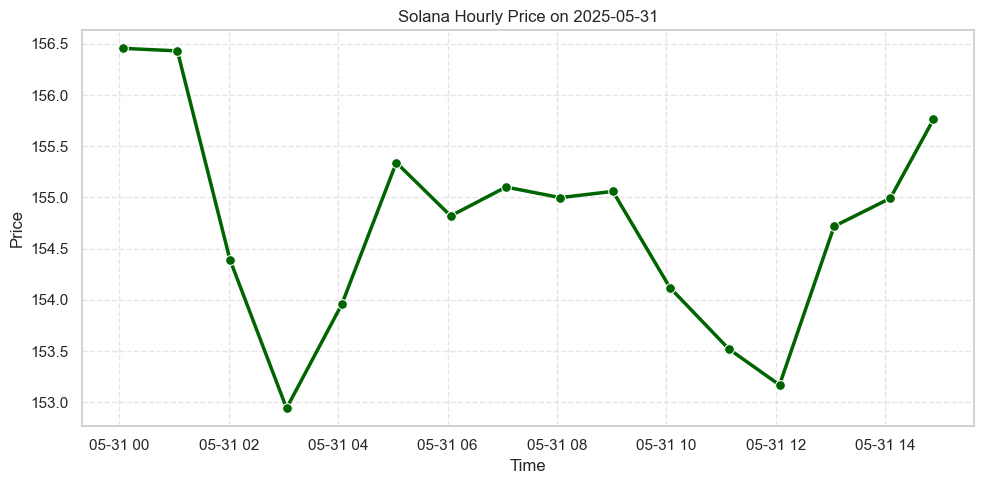

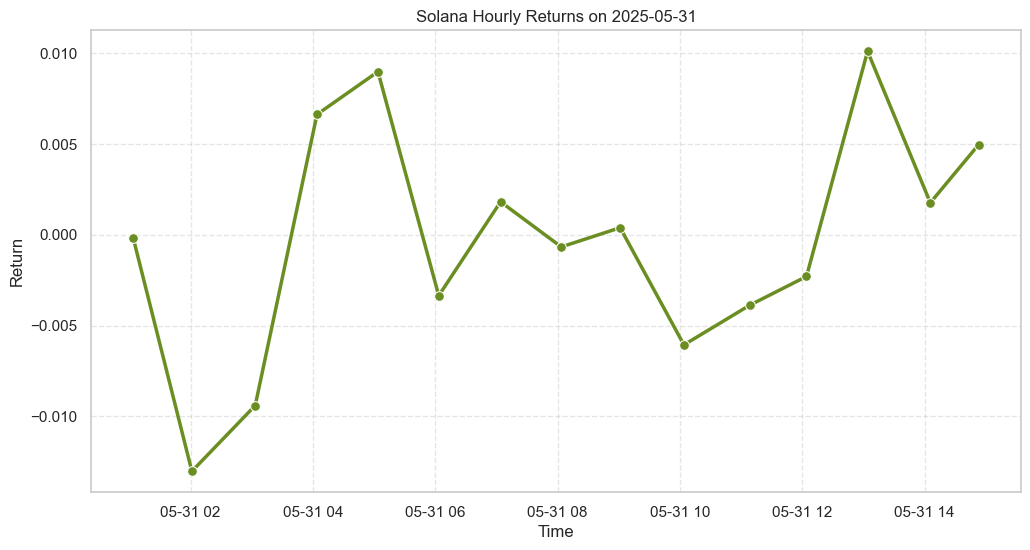

In [9]:
#Hourly Volatility

token =  'solana'

prices = load_token_prices(days = 2, token = token)
day_to_analyse = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 0,0,0) # setting today's datetime but resetting hours,mins and secs to zero
next_day = day_to_analyse + pd.Timedelta(days=1) # set the second day

prices = prices[(prices.index >= day_to_analyse) & (prices.index < next_day)] # deleting from dataset next_day to analyse only today's data hourly (default)
prices['return'] = prices['price'].pct_change() # calculate the percentage change from hour to hour (returns)
volatility = prices['return'].std() # calculate standard deviation of these returns (volatility)
#print(prices)

hours = max(prices.index.hour)
print(f'Volatility of Bitcoin for last {hours} hours:{volatility:.4f}')

plt.figure(figsize=(10,5))
sns.set_theme(style="whitegrid", palette="muted", font_scale=1)
sns.lineplot(data=prices, x=prices.index, y='price', linewidth=2.5, marker='o', markersize=7, color='darkgreen') # visualising price
plt.title(f'{token.capitalize()} Hourly Price on {day_to_analyse.date()}')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True, linestyle = '--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.lineplot(data=prices, x=prices.index, y='return', linewidth=2.5, marker='o', markersize=7, color='olivedrab')
plt.title(f'{token.capitalize()} Hourly Returns on {day_to_analyse.date()}')
plt.xlabel('Time')
plt.ylabel('Return')
plt.grid(True,linestyle='--', alpha=0.5)
plt.show()


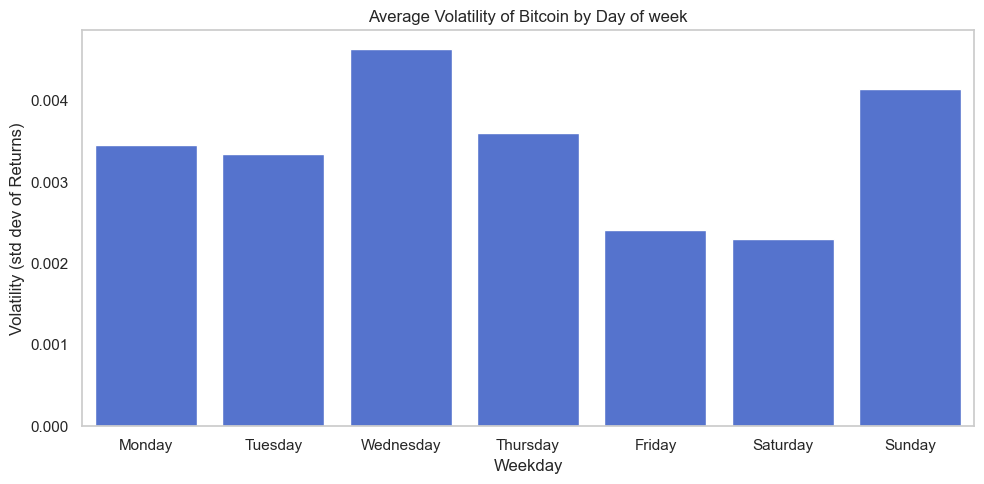

In [10]:
#Weekly Volatility 

days = 30
token = 'bitcoin'

prices = load_token_prices(days, token = token)

df = calculate_volatility(prices, days)

grouped = df.groupby('weekday', observed=True)['volatility'].mean().reset_index() # group calculated average volatilities by weekday

sns.set_theme(style='whitegrid', palette='bright', font_scale=1)
plt.figure(figsize=(10,5))
sns.barplot(data=grouped, x='weekday',y='volatility', color='royalblue' )
plt.title(f'Average Volatility of {token.capitalize()} by Day of week')
plt.xlabel('Weekday')
plt.ylabel('Volatility (std dev of Returns)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


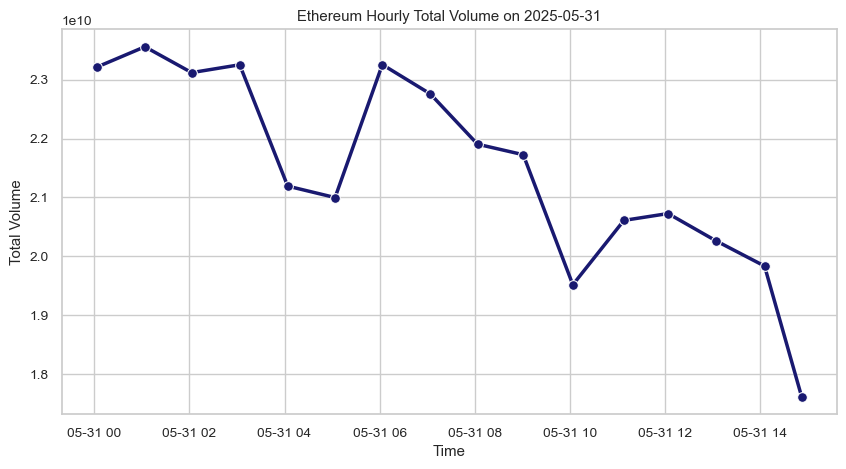

In [11]:
#Hourly Total Volume
token = "ethereum"

volumes = load_token_volumes(days = 2, token = token)

day_to_analyse = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 0,0,0)
next_day = day_to_analyse + pd.Timedelta(days=1)
total_volumes = volumes[(volumes.index >= day_to_analyse) & (volumes.index < next_day)] 
#print(total_volumes)

plt.figure(figsize=(10,5))
sns.set_theme(style="whitegrid", palette="muted", font_scale=0.9)
sns.lineplot(data=total_volumes, x=total_volumes.index, y='total_volume', linewidth=2.5, marker='o', markersize=7, color='midnightblue')
plt.title(f'{token.capitalize()} Hourly Total Volume on {day_to_analyse.date()}')  # visualising price
plt.xlabel('Time')
plt.ylabel('Total Volume')
plt.grid(True)
plt.show()


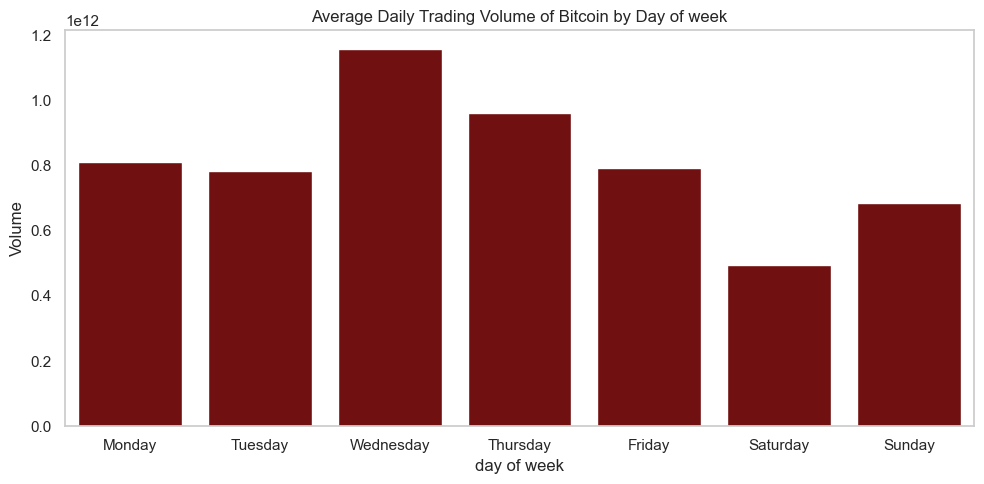

In [12]:
#Weekly Total Volume

days = 30
token = 'bitcoin'

volumes = load_token_volumes(days, token = token)

df = calculate_volume(volumes,days)

grouped = df.groupby('weekday', observed=True)['volume'].mean().reset_index() # grouping and caclulating avg of volumes by weekday

sns.set_theme(style='whitegrid', palette='bright', font_scale=1)
plt.figure(figsize=(10,5))
sns.barplot(data=grouped, x='weekday',y='volume', color='maroon' )
plt.title(f'Average Daily Trading Volume of {token.capitalize()} by Day of week')
plt.xlabel('day of week')
plt.ylabel('Volume')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


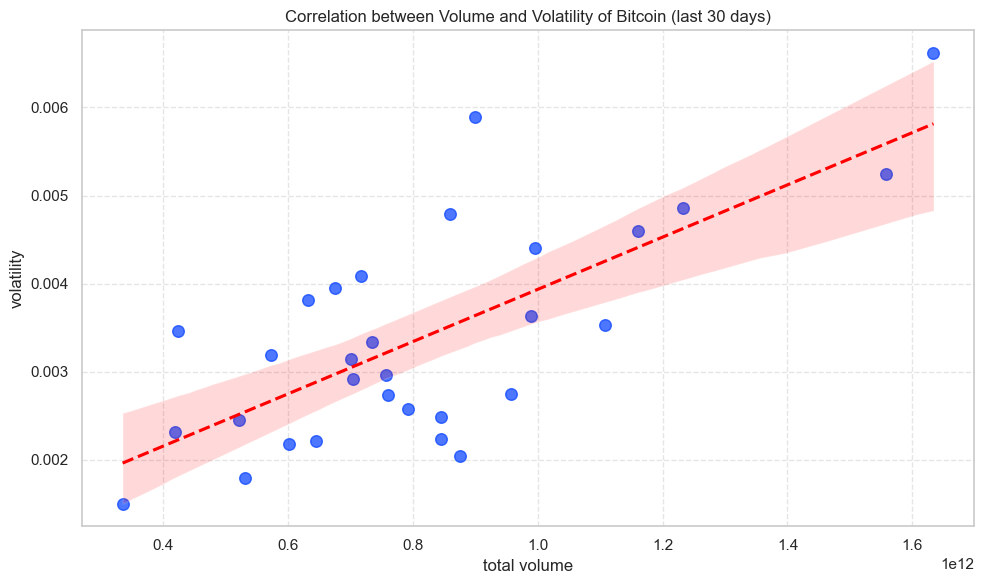

In [13]:
#Correlation of Volume and Volatility

days = 30
token = 'bitcoin'

#extracting price data
prices = load_token_prices(days, token = token)

#extracting total volume data
volumes = load_token_volumes(days, token=token)

#calculating volatilily and volumes for each day
result_volume = calculate_volume(volumes, days)
result_volat = calculate_volatility(prices,days)

full_result = pd.merge(result_volume[['date', 'volume','weekday']], result_volat[['date','volatility']],on='date')

plt.figure(figsize=(10,6))
sns.regplot(x='volume', 
            y='volatility', 
            data=full_result, ci=95, 
            scatter_kws={'s' : 70, 'alpha' : 0.7}, 
            line_kws={'color': 'red', 'linestyle' : '--'})

plt.title(f'Correlation between Volume and Volatility of {token.capitalize()} (last {days} days)')
plt.xlabel('total volume')
plt.ylabel('volatility')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

#corr , p_value = pearsonr(full_result['volume'], full_result['volatility'])
#print(f'Correlation: {corr:4f}')
#print(f'P_Value: {p_value:4f}')

                         total_volume   weekday  hour
timestamp                                            
2025-05-01 15:06:42.291  2.656766e+10  Thursday    15
2025-05-01 16:06:39.128  2.941483e+10  Thursday    16
2025-05-01 17:12:29.704  2.947747e+10  Thursday    17
2025-05-01 18:03:00.814  2.883807e+10  Thursday    18
2025-05-01 19:03:13.844  3.016566e+10  Thursday    19
...                               ...       ...   ...
2025-05-31 11:08:19.505  3.215504e+10  Saturday    11
2025-05-31 12:04:08.742  3.183600e+10  Saturday    12
2025-05-31 13:04:00.047  3.134591e+10  Saturday    13
2025-05-31 14:05:51.916  3.045631e+10  Saturday    14
2025-05-31 14:52:22.000  2.903335e+10  Saturday    14

[720 rows x 3 columns]


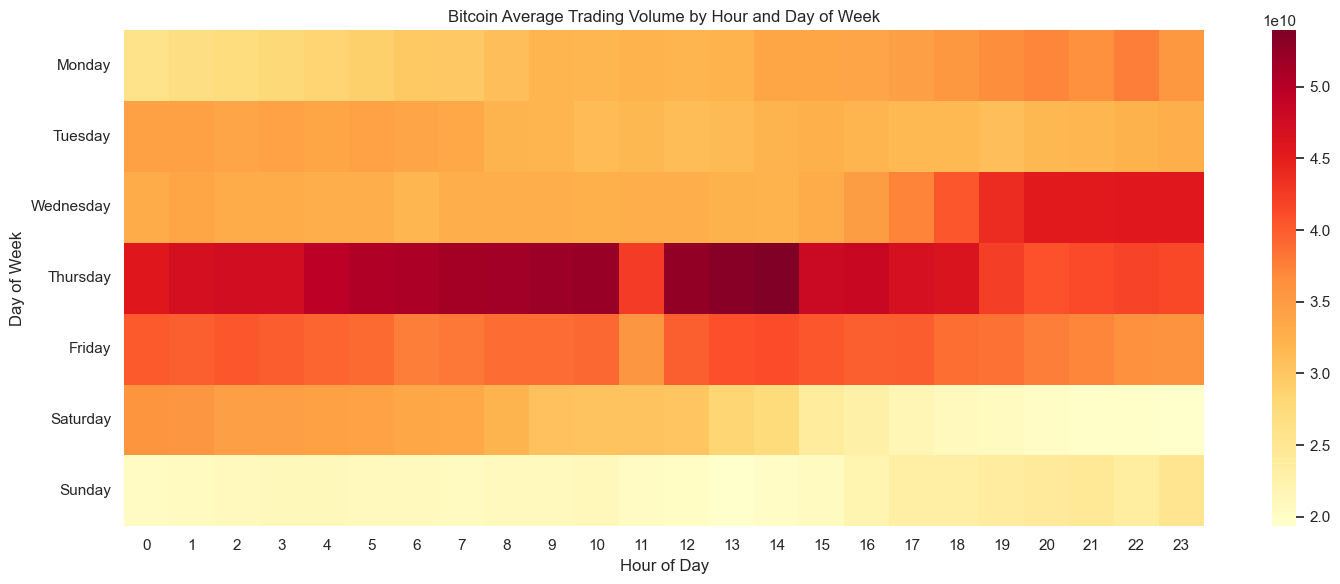

In [14]:
#heatmap volume by hour and weekday

days = 30
token = 'bitcoin'

volumes = load_token_volumes(days, token = token)
volumes['weekday'] = volumes.index.day_name()
volumes['hour'] = volumes.index.hour
print(volumes)

pivot_table = volumes.pivot_table(index='weekday',columns='hour', values='total_volume', aggfunc='mean')
pivot_table = pivot_table.reindex(weekday_order)

plt.figure(figsize=(15,6))
sns.heatmap(pivot_table, cmap='YlOrRd')
plt.title(f'{token.capitalize()} Average Trading Volume by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()


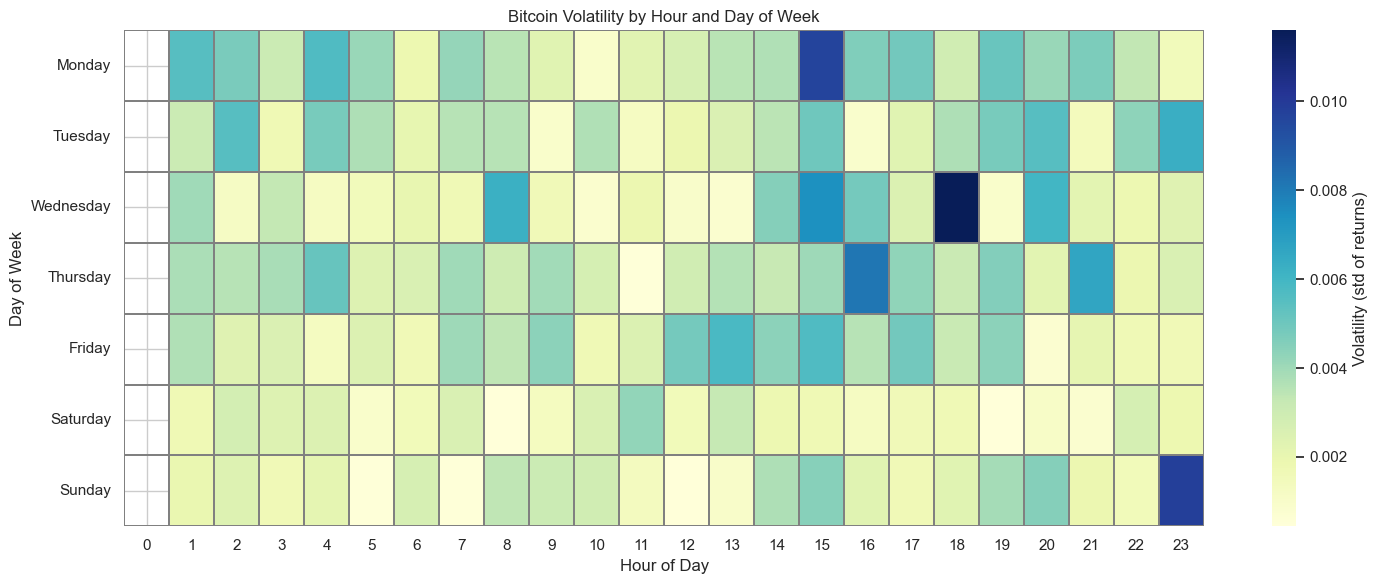

In [15]:
#heatmap volatility by hour and weekday
days = 30
token = 'bitcoin'

prices = load_token_prices(days, token = token)
prices['weekday'] = prices.index.day_name()
prices['hour'] = prices.index.hour
prices['date'] = prices.index.date

prices['return'] = prices.groupby('date')['price'].pct_change()
vol_table = prices.groupby(['weekday','hour'])['return'].std().unstack()
vol_table= vol_table.reindex(weekday_order)

#print(vol_table)
plt.figure(figsize=(15,6))
sns.heatmap(vol_table, cmap='YlGnBu', annot=False, linewidths=0.3,linecolor='gray', cbar_kws={'label':'Volatility (std of returns)'})
plt.title(f'{token.capitalize()} Volatility by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

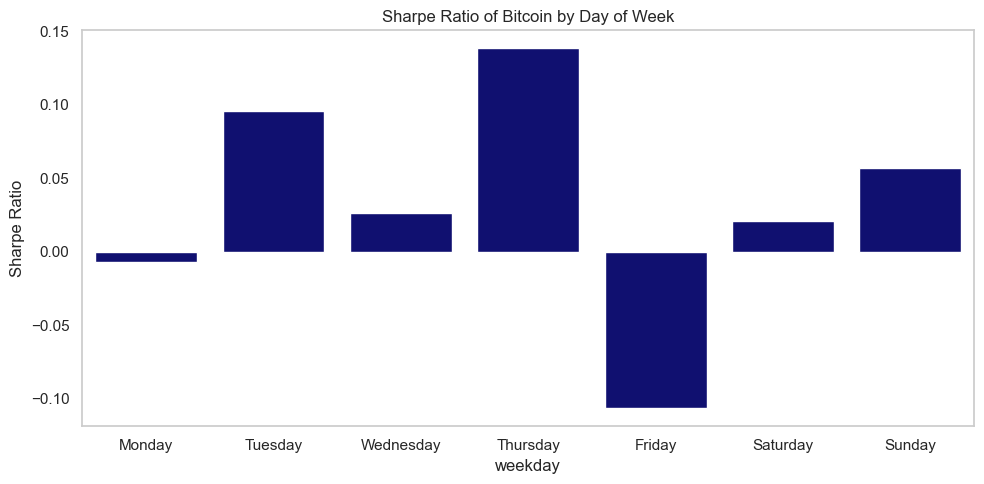

In [16]:
# Sharpe Ratio by Weekday

days = 30
token ='bitcoin'

df_ratio = load_token_prices(days, token = token)
df_ratio['return'] = df_ratio['price'].pct_change()
df_ratio['weekday'] = df_ratio.index.day_name()

sharpe_by_day = df_ratio.groupby('weekday').agg( #grouping by weekday and calculating avg returns by weekday and volatility
    mean_return=('return', 'mean'),
    volatility=('return', 'std')
)

sharpe_by_day['sharpe_ratio'] = sharpe_by_day['mean_return'] / sharpe_by_day['volatility'] # calculating sharpe ratio for each weekday
sharpe_by_day = sharpe_by_day.loc[weekday_order]

plt.figure(figsize=(10,5))
sns.set_theme(style='whitegrid', palette='deep', font_scale=1)
sns.barplot(data=sharpe_by_day, x=sharpe_by_day.index,y='sharpe_ratio', color='navy' )
plt.title(f'Sharpe Ratio of {token.capitalize()} by Day of Week')
plt.ylabel('Sharpe Ratio')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


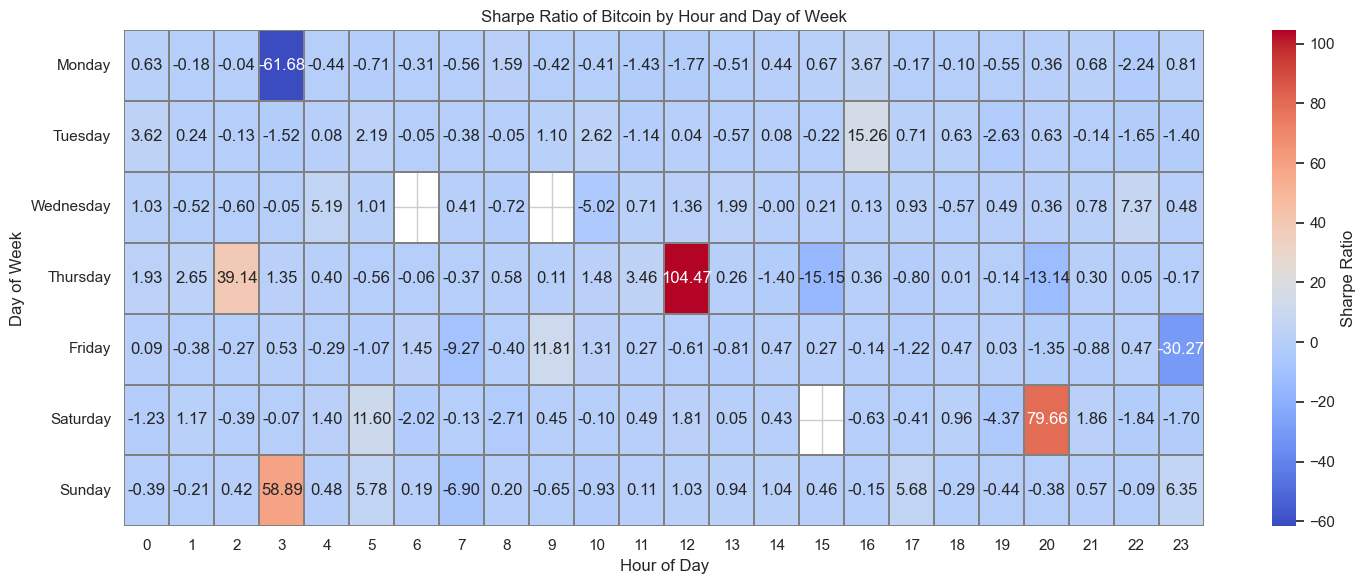

In [17]:
# heatmap sharpe ratio

days = 14
token = 'bitcoin' 

prices = load_token_prices(days, token = token)
prices['return'] = prices['price'].pct_change()
prices['weekday'] = prices.index.day_name()
prices['hour'] = prices.index.hour

grouped = prices.groupby(['weekday', 'hour']).agg(
    mean_return=('return', 'mean'),
    volatility=('return', 'std')
)

grouped['sharpe_ratio'] = grouped['mean_return'] / grouped['volatility']

pivot_table = grouped['sharpe_ratio'].unstack()
pivot_table = pivot_table.reindex(weekday_order)


plt.figure(figsize=(15,6))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.3, linecolor='gray', cbar_kws={'label': 'Sharpe Ratio'})
plt.title(f'Sharpe Ratio of {token.capitalize()} by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

In [56]:
import numpy as np
import pandas as pd

token = 'solana'

def biggest_moves(prices, window=5, n_results=None, direction="both", allow_overlap=False):
    if "price" not in prices:
        raise ValueError("prices DataFrame must contain column 'price'")

    # Calculate % change
    pct_change = prices["price"].pct_change(periods=window) * 100

    # Create the DataFrame
    df = pd.DataFrame({
        "end_price": prices["price"],
        "pct_change": pct_change
    }).dropna()

    df["start_price"] = df["end_price"].shift(window)
    df["start"] = df.index - pd.Timedelta(days=window)
    df["end"] = df.index
    df["direction"] = np.where(df["pct_change"] > 0, "up", "down")
    df["abs_move"] = df["pct_change"].abs()

    # Filter by direction
    if direction in {"up", "down"}:
        df = df[df["direction"] == direction]

    # Sort by absolute move
    ranked = df.sort_values("abs_move", ascending=False)

    # Remove overlapping periods
    if not allow_overlap:
        kept_idx, spans = [], []
        for idx, row in ranked.iterrows():
            s, e = row["start"], row["end"]
            if not any((s <= ee) and (e >= ss) for ss, ee in spans):
                kept_idx.append(idx)
                spans.append((s, e))
            if n_results is not None and len(kept_idx) == n_results:
                break
        ranked = ranked.loc[kept_idx]

    # Final output
    result = (
        ranked[["start", "end", "start_price", "end_price", "pct_change", "direction"]]
        .sort_values("pct_change", ascending=(direction == "down"))
        .head(n_results)
        .reset_index(drop=True)
        .round({"start_price": 2, "end_price": 2, "pct_change": 2})
    )
    return result

prices = load_token_prices(days=365,token=token)

In [57]:
role = """You are a crypto-market analyst.

Respond ONLY in **German**, regardless of the input language.
For choosed token price change, return a explanation of the cause with the following fields:
- Zeitraum (start bis end)
- Preisänderung
- Ursache (in detail but in one-two sentences)
- Ereignistyp (z.B. Politisch, Markt, Regulierung, Unbekannt)
- Vertrauensniveau (Hoch, Mittel, Gering)
- Quellen (URLs)

Antworte ausschließlich mit gültigem JSON im folgenden Format:
[
  {
    "zeitraum": "...",
    "preisänderung": "...",
    "ursache": "...",
    "ereignistyp": "...",
    "vertrauen": "...",
    "quellen": ["..."]
  }
]
No extra text, no commentary, no formatting."""

In [59]:
from openai import OpenAI
import os
from dotenv import load_dotenv
import json
import textwrap

load_dotenv()

client = OpenAI(
    api_key = os.getenv('OPENAI_API_KEY')
    )

result = biggest_moves(prices, window=7, n_results=3)
print(result)

message = f'{token} , period: from {result['start']} to {result['end']}, return {result['pct_change']}'

response = client.chat.completions.create(
  model="gpt-4o-search-preview",
  messages=[
    {
      "role": "system",
      "content": [
        {
          "text": role,
          "type": "text"
        }
      ]
    },
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": message
        }
      ]
    }
  ],
  response_format={
    "type": "text"
  },
  web_search_options={
    "user_location": {
      "type": "approximate",
      "approximate": {
        "country": "DE"
      }
    }
  }
)

json_str = response.choices[0].message.content
events = json.loads(json_str)

for event in events:
    print(f"\nZeitraum: {event['zeitraum']}")
    print(f"Preisänderung: {event['preisänderung']}")
    print(textwrap.fill(event['ursache'], width=80))
    print(f"Ereignistyp: {event['ereignistyp']}")
    print(f"Vertrauen: {event['vertrauen']}")
    print("Quellen:")
    for url in event['quellen']:
        print(f"  - {url}")
    print()


       start        end  start_price  end_price  pct_change direction
0 2024-11-05 2024-11-12       157.61     222.64       41.26        up
1 2025-01-12 2025-01-19       188.06     262.56       39.61        up
2 2024-07-30 2024-08-06       182.54     129.70      -28.95      down

Zeitraum: 5. November 2024 bis 12. November 2024
Preisänderung: +41,26%
Solana erreichte am 11. November 2024 ein Jahreshoch von 224 US-Dollar, gefolgt
von einer Korrektur auf etwa 208,86 US-Dollar am 12. November, ausgelöst durch
Gewinnmitnahmen und überkaufte Marktbedingungen.
Ereignistyp: Markt
Vertrauen: Hoch
Quellen:
  - https://de.tradingview.com/news/invezz%3Aeca86ba28600c%3A0/


Zeitraum: 12. Januar 2025 bis 19. Januar 2025
Preisänderung: +39,61%
Der Solana-Kurs stieg aufgrund des Hypes um den auf Solana basierenden TRUMP-
Token, der das Handelsvolumen und die Netzwerkaktivität erheblich steigerte.
Ereignistyp: Markt
Vertrauen: Hoch
Quellen:
  - https://www.binance.com/de/square/post/19274085265194


Z